In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
# 上傳csv檔案,在run此code前請先幫我載入助教提供的csv檔案(stock.csv)
uploaded = files.upload()


Saving stock.csv to stock (1).csv


In [5]:
import io
import pandas as pd
data_df = pd.read_csv(io.BytesIO(uploaded['stock.csv']))
data_df

,date,open
0,2013/2/8,15.07
1,2013/2/11,14.89
2,2013/2/12,14.45
3,2013/2/13,14.30
4,2013/2/14,14.94
...,...,...
1254,2018/2/1,54.00
1255,2018/2/2,53.49
1256,2018/2/5,51.99
1257,2018/2/6,49.32


Text(0, 0.5, 'Price')

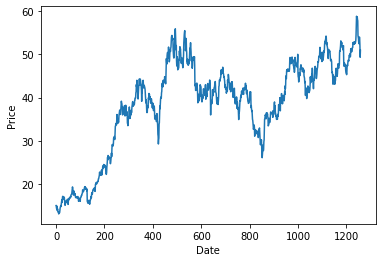

In [6]:
data_df['open'].plot()
plt.xlabel('Date')
plt.ylabel('Price')

In [7]:
#利用MinMaxScaler 最小最大值標準化
from sklearn.preprocessing import MinMaxScaler
data_rehsape = data_df['open'].values.reshape(-1,1).astype('float32')
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data_rehsape)

In [8]:
#基於前三天的資料來預測下一天
look_back = 3
train_size = 250
#劃分成訓練與測試資料集
train, test = training_set_scaled[:-train_size], training_set_scaled[-train_size-look_back:] 

In [9]:
print('train shape:', train.shape)
print('test shape:', test.shape)
train[1008][0]

train shape: (1009, 1)
test shape: (253, 1)


0.6994523

In [10]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(dataset.shape[0]-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back-1, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
#生成新樣本
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print('trainX:',trainX.shape)
print('trainY:',trainY.shape)


trainX: (1006, 3)
trainY: (1006,)


In [12]:
#放入LSTM的shape
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print('trainX.shape:',trainX.shape)
print('testX.shape:',testX.shape)

trainX.shape: (1006, 3, 1)
testX.shape: (250, 3, 1)


In [13]:
trainY = np.reshape(trainY,(trainY.shape[0], 1))
testY = np.reshape(testY,(testY.shape[0], 1))
print('trainY.shape:',trainY.shape)
print('testY.shape:',testY.shape)


trainY.shape: (1006, 1)
testY.shape: (250, 1)


Text(0, 0.5, 'Price')

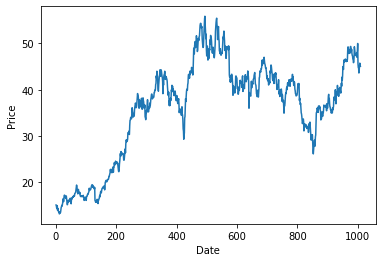

In [14]:
len_train = np.linspace(0, train.shape[0],train.shape[0]+1)
plt.plot(len_train[1:],sc.inverse_transform(train.reshape(-1,1)))
#plt.plot(len_test[1:],sc.inverse_transform(y_hat))
plt.xlabel('Date') # set a xlabel
plt.ylabel('Price')

Text(0, 0.5, 'Price')

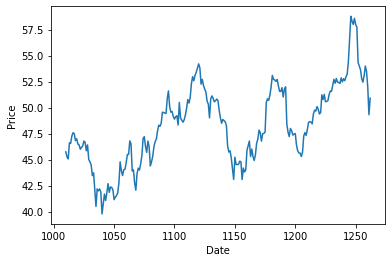

In [15]:
len_test = np.linspace(train.shape[0], test.shape[0]+train.shape[0],test.shape[0]+1)
plt.plot(len_test[1:],sc.inverse_transform(test.reshape(-1,1)))
#plt.plot(len_test[1:],sc.inverse_transform(y_hat))
plt.xlabel('Date') # set a xlabel
plt.ylabel('Price')

Hw:create a lstm model to predict stock price

In [16]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [17]:
# 建立及訓練 LSTM 模型
model = Sequential()
model.add(LSTM(3, input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [36]:
#Fit model with history to check for overfitting
history = model.fit(trainX,trainY,epochs=100,validation_data=(testX,testY),shuffle=False,batch_size=5)

Epoch 1/100
202/202 [==============================] - 1s 6ms/step - loss: 7.2181e-05 - val_loss: 1.1464e-04
Epoch 2/100
202/202 [==============================] - 1s 3ms/step - loss: 3.1347e-05 - val_loss: 7.3687e-05
Epoch 3/100
202/202 [==============================] - 1s 4ms/step - loss: 3.3198e-05 - val_loss: 5.9120e-05
Epoch 4/100
202/202 [==============================] - 1s 3ms/step - loss: 3.0012e-05 - val_loss: 5.0964e-05
Epoch 5/100
202/202 [==============================] - 1s 4ms/step - loss: 2.4634e-05 - val_loss: 4.5117e-05
Epoch 6/100
202/202 [==============================] - 1s 3ms/step - loss: 2.0472e-05 - val_loss: 4.0826e-05
Epoch 7/100
202/202 [==============================] - 1s 3ms/step - loss: 1.7634e-05 - val_loss: 3.7684e-05
Epoch 8/100
202/202 [==============================] - 1s 4ms/step - loss: 1.5869e-05 - val_loss: 3.5353e-05
Epoch 9/100
202/202 [==============================] - 1s 3ms/step - loss: 1.4901e-05 - val_loss: 3.3554e-05
Epoch 10/100
202/20

In [37]:
# save model
model.save_weights("model.hdf5")


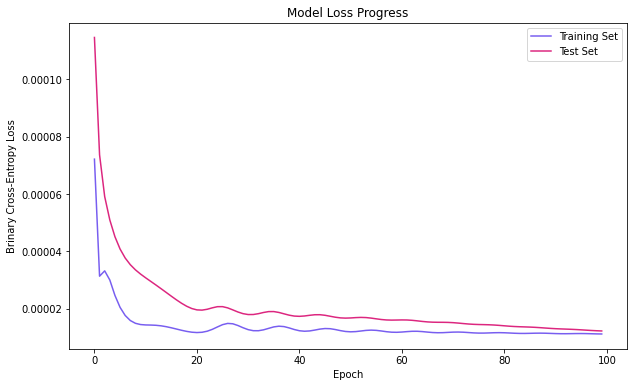

In [38]:
#plot training process
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='#785ef0')
plt.plot(history.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Brinary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

In [42]:
model.evaluate(testX,testY)

8/8 [==============================] - 0s 3ms/step - loss: 1.2230e-05


1.2229897038196214e-05

In [47]:
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [52]:
testY = pd.DataFrame(testY)
testY

,0
0,0.699452
1,0.733406
2,0.732092
3,0.747426
4,0.754655
...,...
245,0.874918
246,0.895071
247,0.883899
248,0.851040


In [62]:
predictY = model.predict(testX)


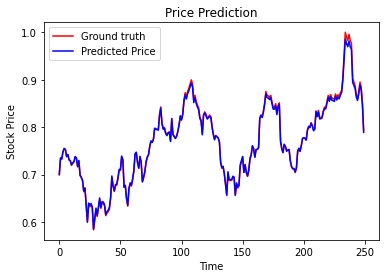

In [63]:
import matplotlib.pyplot as plt 
plt.plot(testY, color = 'red', label = 'Ground truth')  # 紅線表示真實股價
plt.plot(predictY, color = 'blue', label = 'Predicted Price')  # 藍線表示預測股價
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [65]:
testY

,0
0,0.699452
1,0.733406
2,0.732092
3,0.747426
4,0.754655
...,...
245,0.874918
246,0.895071
247,0.883899
248,0.851040


In [68]:
from keras.models import load_model

model.save('model.h5') 